In [1]:
using Oceananigans
using JLD2
using CairoMakie
using Statistics
using ImageFiltering: imfilter, Kernel.gaussian
using ZipFile

[ Info: Oceananigans will use 4 threads


In [7]:
runname = "default"
@inline function makesecondarycirculationvid(runname, i=nothing)
    foldername = "../scratch/filament-instability/$runname"
    filename = "down_front_mean.jld2"
    ωfilename = "secondary_circulation.jld2"
    frames, grid = jldopen("$foldername/$filename") do file
        keys(file["timeseries/t"]), file["serialized/grid"]
        end;
    xᶜᵃᵃ = xnodes(Center, grid)
    xᶠᵃᵃ = xnodes(Face, grid)
    zᵃᵃᶜ = znodes(Center, grid)
    zᵃᵃᶠ = znodes(Face, grid)

    file = jldopen("$foldername/$filename")
    ωfile = jldopen("$foldername/$ωfilename")

    n = Observable(101)

    frame = @lift frames[$n]
    
    ts = [file["timeseries/t/$f"] for f in frames] .- 1

    b = @lift file["timeseries/b_dfm/$($frame)"][:, 1, :]
    ω = @lift ωfile["timeseries/ω/$($frame)"][:, 1, :] 
    ω_depth = @lift sqrt.(ωfile["timeseries/ω_depth/$($frame)"][1, 1, :])
    # Get the secondary cirulation streamfunction
    σ=3

    title = @lift "$runname, t = $(round(ts[$n]; digits=2))"
    
    axis_kwargs = (; xlabel="x", ylabel="z", title, limits=(-2, 0, -0.12, 0))

    fig = Figure(resolution=(1200, 600))
    fig[1, 1:3] = Label(fig, title, fontsize=20)
    axω = Axis(fig[2, 1]; title=L"\langle \omega \rangle", axis_kwargs...)
    axω_depth = Axis(fig[2, 3]; xlabel="RMS", ylabel="z", limits=(0, 10, -0.12, 0))
    
    ht1 = heatmap!(axω, xᶜᵃᵃ, zᵃᵃᶠ, ω; colormap=:balance, colorrange=(-50, 50))
    
    for ax in [axω]
        contour!(ax, xᶜᵃᵃ, zᵃᵃᶜ, b; color=(:black, 1), levels=range(-200, 200, 160), linewidth=1.5)
    end
    Colorbar(fig[2, 2], ht1, label=L"\omega")
    lines!(axω_depth, ω_depth, zᵃᵃᶠ)
    
    if i != nothing
        n[] = i
        return fig
    end
    
    vidfoldername = "output/videos/$runname/vorticity"
    !ispath(vidfoldername) && mkpath(vidfoldername)
    w = ZipFile.Writer("$vidfoldername.zip");
    for i in 101:length(frames)
        n[] = i
        zipfile = ZipFile.addfile(w, "$(lpad(i, 4, '0')).png");
        save("$vidfoldername/$(lpad(i, 4, '0')).png", fig; resolution=(1200, 600))
        open(r -> write(zipfile, r), "$vidfoldername/$(lpad(i, 4, '0')).png")
        close(zipfile)
        rm("$vidfoldername/$(lpad(i, 4, '0')).png")
    end
    close(file)
    rm("$vidfoldername")
    close(w)
    fig
end

makesecondarycirculationvid (generic function with 2 methods)

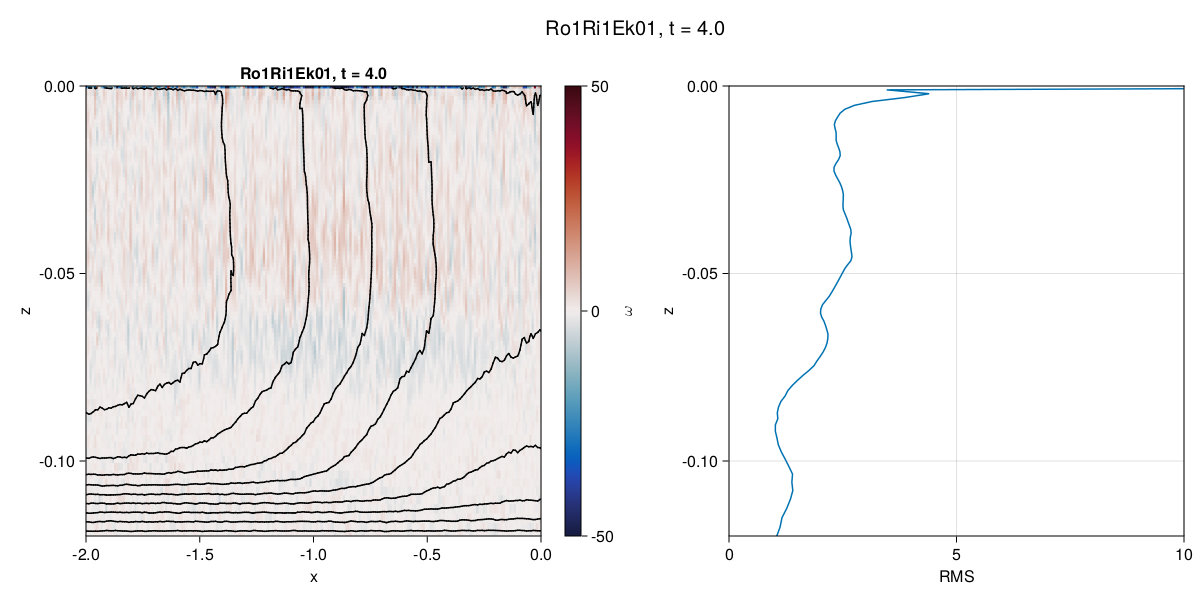

In [31]:
makesecondarycirculationvid("Ro1Ri1Ek01", 501)

In [34]:
runname = "default"
@inline function makesecondarycirculationtimeseries(runname)
    foldername = "../scratch/filament-instability/$runname"
    filename = "down_front_mean.jld2"
    ωfilename = "secondary_circulation.jld2"
    frames, grid = jldopen("$foldername/$filename") do file
        keys(file["timeseries/t"]), file["serialized/grid"]
        end;
    xᶜᵃᵃ = xnodes(Center, grid)
    xᶠᵃᵃ = xnodes(Face, grid)
    zᵃᵃᶜ = znodes(Center, grid)
    zᵃᵃᶠ = znodes(Face, grid)
    Δzᵃᵃᶠ = grid.Δzᵃᵃᶠ[1:129]
    σ=3
    ωfile = jldopen("$foldername/$ωfilename")
    ω_depth = [sqrt(sum(sum(imfilter(ωfile["timeseries/ω/$frame"][:, 1, :], gaussian((σ, 0), (4σ+1, 5)), "circular") .^ 2; dims=1)[1, 1, :] .* Δzᵃᵃᶠ) / sum(Δzᵃᵃᶠ)) for frame in frames[end-1000:end]]
    close(ωfile)
    return ω_depth
end

makesecondarycirculationtimeseries (generic function with 1 method)

In [54]:
Ros = ["1"]
Ris = ["02", "06", "1"]
Eks = ["0", "01", "1"]
runnames = ["Ro$(Ro)Ri$(Ri)Ek$(Ek)" for Ro in Ros, Ri in Ris, Ek in Eks]
ω_depths = map(makesecondarycirculationtimeseries, runnames);

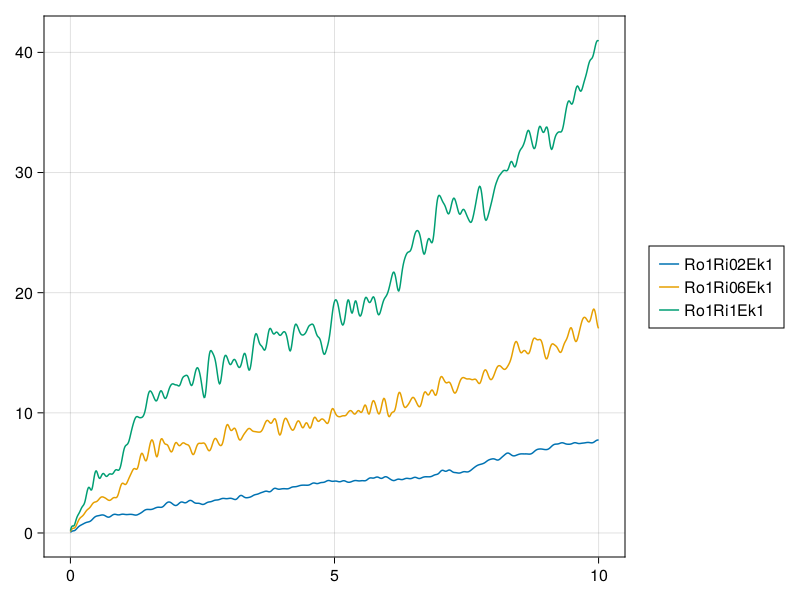

In [58]:
fig = Figure()
ax = Axis(fig[1, 1])
lns = [lines!(ax, range(0, 10, 1000), ω_depth[2:end]) for ω_depth in ω_depths[1, 1:3, 3]]
Legend(fig[1, 2], lns, runnames[1, 1:3, 3])
fig

In [18]:
ω_depths

1×4×3 Array{Vector{Float64}, 3}:
[:, :, 1] =
 [7.25539e-16, 0.00113192, 0.00214367, 0.00308899, 0.00396961, 0.00478847, 0.00554833, 0.00625181, 0.00692972, 0.00755356  …  0.244314, 0.243169, 0.242045, 0.240942, 0.239856, 0.238789, 0.237737, 0.2367, 0.235677, 0.234665]  …  [8.70634e-16, 0.00113219, 0.00215516, 0.00311712, 0.0040199, 0.00486621, 0.0056586, 0.00639945, 0.00711375, 0.00777867  …  0.113468, 0.113432, 0.113399, 0.113368, 0.11334, 0.113312, 0.113287, 0.113264, 0.113244, 0.113227]

[:, :, 2] =
 [0.0385749, 0.00293077, 0.00565444, 0.00809144, 0.0102092, 0.0119468, 0.0133079, 0.0142616, 0.0148561, 0.0151086  …  0.607324, 0.608711, 0.610095, 0.611474, 0.612826, 0.614158, 0.615451, 0.616713, 0.617951, 0.61916]  …  [0.472416, 0.0110074, 0.0211391, 0.0300679, 0.0375411, 0.043394, 0.0475642, 0.0501061, 0.0512056, 0.0511877  …  1.69241, 1.69007, 1.68822, 1.68701, 1.68661, 1.68718, 1.68888, 1.6918, 1.69603, 1.70152]

[:, :, 3] =
 [1.00899e-14, 0.0138532, 0.0275932, 0.0408425, 0.0532534